# Load Data

In [1]:
import pickle
import os
from tqdm import tqdm
import numpy as np

directory = 'data/train'

length_list = []
valence_values=[]

recordings = []

for filename in tqdm(os.listdir(directory)):
    if filename.endswith('.pkl'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            if data['valence'] != 2.333:
                length_list.append(len(data['audio_data']))
                valence_values.append(data['valence'])
                recordings.append(data['audio_data'])

valence_values = np.array(valence_values)


100%|██████████| 10557/10557 [00:21<00:00, 485.95it/s] 


In [2]:
valennce_dist ={}
for i in valence_values:
    if i in valennce_dist:
        valennce_dist[i] += 1
    else:
        valennce_dist[i] = 1


valennce_dist


{1.25: 140,
 3.5: 1194,
 3.25: 1299,
 3.75: 989,
 2.0: 528,
 2.75: 1031,
 2.25: 694,
 3.0: 1063,
 4.25: 613,
 1.0: 114,
 1.5: 229,
 1.75: 408,
 4.75: 151,
 4.0: 801,
 2.5: 907,
 5.0: 28,
 4.5: 367}

In [3]:
# Calculate the maximum length
max_length = max(length_list)

# Adjust the recordings to have the same length
adjusted_recordings = []
for recording in recordings:
    # Repeat the array until it reaches or exceeds the maximum length
    repeated_recording = np.tile(recording, (max_length // len(recording) + 1))[:max_length]
    adjusted_recordings.append(repeated_recording)

valence_values = np.array(valence_values)
len(adjusted_recordings), adjusted_recordings[0].shape



(10556, (174625,))

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


############################################################################################################


############################################################################################################
# Pad the recordings to have the same length
max_length = max(len(array) for array in recordings)  # Find the maximum length

# # Pad each array to have the maximum length
# padded_arrays = np.array([np.pad(array, (0, max_length - len(array)), mode='constant') for array in recordings])


############################################################################################################
# Split the data and labels into training and testing sets
X_train, X_test_help, y_train, y_test_help = train_test_split(adjusted_recordings, valence_values, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test_help, y_test_help, test_size=0.5, random_state=42)



############################################################################################################
# Create a DataLoader for the training set, test set, and validation set

batch_size = 256  # You can adjust the batch size depending on your system's capability

# Convert input data and labels to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Use float32 for input features
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Use float32 for labels

# Create a dataset from tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

############################################################################################################
# Repeat the same process for the test set

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



############################################################################################################
# Repeat the same process for the validation set
X_validation_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
y_validation_tensor = torch.tensor(y_val, dtype=torch.float32)

validation_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)




C:\Users\20211922\AppData\Local\Temp\ipykernel_10176\108390367.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Use float32 for input features


In [5]:
import matplotlib.pyplot as plt

def calculate_label_distribution(labels_tensor):
    label_dist = {}
    for label in labels_tensor:
        label = label.item()  # Convert tensor to int
        if label in label_dist:
            label_dist[label] += 1
        else:
            label_dist[label] = 1
    return label_dist

train_labels = train_loader.dataset.tensors[1]

train_valence_dist = calculate_label_distribution(train_labels)






# Augment Data

In [6]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, RoomSimulator, Aliasing, HighPassFilter, LowPassFilter,ApplyImpulseResponse
import numpy as np
import torch
import sounddevice as sd
import random


def draw_augmentations(text,amount,fs=12000):
    
    augmentGaussian = Compose([
        AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=1),
    ])

    augmentPitchShift = Compose([
        PitchShift(min_semitones=-4, max_semitones=4, p=1),
    ])

    # augmentRoomSimulator = Compose([
    #     RoomSimulator(p=1)
    # ])

    augmentAliasing = Compose([
        Aliasing(min_sample_rate=8000, max_sample_rate=30000,p=1)
    ])

    augmentHPF = Compose([
        HighPassFilter(min_cutoff_freq=15, max_cutoff_freq=2400,p=1)
        ])

    augmentedLPF = Compose([
        LowPassFilter(p=1)
    ])


    list_of_augmentations = [ augmentGaussian, augmentPitchShift, augmentAliasing, augmentHPF, augmentedLPF]

    functions = random.sample(list_of_augmentations, amount,)
    for i in functions:
        # print(i.__name__)
        text = i(text, sample_rate=fs)
    # sd.play(text, fs)
    return text


In [7]:

waveforms = train_loader.dataset.tensors[0].numpy().squeeze()  # Convert tensor to NumPy array
labels = train_loader.dataset.tensors[1].numpy().squeeze()  # Convert tensor to NumPy array


# Create a dictionary to hold the data categorized by labels
label_dict = {}

# Iterate through each label and corresponding waveform
for waveform, label in zip(waveforms, labels):
    if label not in label_dict:
        label_dict[label] = []
    label_dict[label].append(waveform)


# for label in label_dict:
#     for k in label_dict[label]:
#         print(k.shape)
        





In [8]:
from tqdm import tqdm
def train_balancer(train_valence_dist):
    train_balanced = {}
    for label in train_valence_dist.keys():
        train_balanced[label] = []
    for label in tqdm(train_valence_dist.keys()):
        for recording in range(len(label_dict[label])):
            train_balanced[label].append(label_dict[label][recording])

        amount = len(label_dict[label])
        for _ in range(round(amount*0.25)):
            choose_func_amount = random.randint(1, 3)
            choose_index = random.randint(0, len(label_dict[label])-1)
            train_balanced[label].append(draw_augmentations(label_dict[label][choose_index],choose_func_amount))

    return train_balanced


train_balanced = train_balancer(train_valence_dist= train_valence_dist)
print(train_balanced.keys())
        

  0%|          | 0/17 [00:00<?, ?it/s]

100%|██████████| 17/17 [00:58<00:00,  3.47s/it]

dict_keys([3.0, 2.75, 2.5, 3.25, 4.25, 3.5, 3.75, 2.25, 1.5, 4.0, 1.75, 1.0, 2.0, 4.5, 4.75, 1.25, 5.0])


In [9]:
# for d in train_balanced:
#     for i in train_balanced[d]:
#         print(i.shape)

In [10]:
def array_to_hashable(arr):
    return hash(arr.tobytes())

for arrays in train_balanced.keys():
    print("Label: ", arrays)
    # Convert each array to a hashable type
    unique_hashes = set(array_to_hashable(arr) for arr in train_balanced[arrays])

    # The number of unique arrays
    num_unique_arrays = len(unique_hashes)
    print("Number of unique arrays for : ", num_unique_arrays)

    

Label:  3.0
Number of unique arrays for :  779
Label:  2.75
Number of unique arrays for :  770
Label:  2.5
Number of unique arrays for :  669
Label:  3.25
Number of unique arrays for :  979
Label:  4.25
Number of unique arrays for :  454
Label:  3.5
Number of unique arrays for :  929
Label:  3.75
Number of unique arrays for :  736
Label:  2.25
Number of unique arrays for :  525
Label:  1.5
Number of unique arrays for :  178
Label:  4.0
Number of unique arrays for :  611
Label:  1.75
Number of unique arrays for :  306
Label:  1.0
Number of unique arrays for :  92
Label:  2.0
Number of unique arrays for :  398
Label:  4.5
Number of unique arrays for :  264
Label:  4.75
Number of unique arrays for :  110
Label:  1.25
Number of unique arrays for :  95
Label:  5.0
Number of unique arrays for :  22


In [11]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np



test_dict = train_balanced

# Flatten the dictionary into lists of samples and labels
X_train = []
y_train = []
for label, arrays in tqdm(test_dict.items()):
    for array in arrays:
        X_train.append(array)
        y_train.append(label)  # Adjust how labels are encoded as needed


# Convert lists to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Use float32 for input features
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Adjust the type depending on how you encode labels

# Create a dataset from tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Define the batch size
batch_size = 256  # Adjust batch size based on your system capability

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(train_loader.dataset.tensors[0].shape)

100%|██████████| 17/17 [00:00<00:00, 3112.32it/s]


torch.Size([7917, 1, 174625])


# **MODEL**

In [12]:
def round_to_nearest_quarter(number):
    # Assuming 'number' could be a numpy array with a single value
    if isinstance(number, np.ndarray) and number.size == 1:
        number = number.item()  # Convert single-item array to scalar
    
    # Ensure the number is within the 1 to 5 range before processing
    number = np.clip(number, 1, 5)
    # Scale number to shift quarters to whole numbers, round, and rescale
    rounded_number = np.round(number * 4) / 4
    # Clip again to ensure no out-of-range values after rounding
    rounded_number = np.clip(rounded_number, 1, 5)
    return str(rounded_number)

In [13]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torchaudio.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

models = {}


class ResidualBlock(nn.Module):
    def __init__(self, channels, kernel_size=7, dilation=2):
        super(ResidualBlock, self).__init__()


        padding = (kernel_size - 1) * dilation // 2  

        # 1st Convolutional Layer
        self.conv1 = nn.Conv1d(channels, channels, kernel_size=kernel_size, padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(channels)
        self.relu = nn.ReLU(inplace=True)

        # 2nd Convolutional Layer
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=kernel_size, padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(channels)

    def forward(self, x):
        residual = x  
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        #  addition of input to the output -- residual connection
        out += residual  
        out = self.relu(out)
        return out

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Random seed for reproducibility
        torch.manual_seed(42)


        self.mfcc_transform = transforms.MFCC(
            sample_rate=8000,      ## 
            n_mfcc=24              ## Created channels
        )


        self.layers = nn.ModuleList()
        
        # Start with 1D BatchNorm
        self.layers.append(nn.BatchNorm1d(24))


        ###########################
        # 1st Convolutional Layer
        ###########################

        conv1 = nn.Conv1d(in_channels=24, out_channels=64, kernel_size=7, padding=1)
        # Initialize the weight using He initialization
        nn.init.kaiming_normal_(conv1.weight, nonlinearity='relu')
        self.layers.append(conv1)
        self.layers.append(nn.BatchNorm1d(64))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=3))
        self.layers.append(nn.Dropout(0.3))

        ###########################
        # Residual Block
        ###########################
        self.layers.append(ResidualBlock(64))

        ###########################
        # 2nd Convolutional Layer
        ###########################
        
        conv2 = nn.Conv1d(in_channels=64, out_channels=48, kernel_size=7, padding=1)
        # He initialization
        nn.init.kaiming_normal_(conv2.weight, nonlinearity='relu')
        self.layers.append(conv2)
        self.layers.append(nn.BatchNorm1d(48))
        self.layers.append(nn.ReLU())

        ###########################
        # 3rd Convolutional Layer
        ###########################

        conv3 = nn.Conv1d(in_channels=48, out_channels=12, kernel_size=7, padding=1,dilation=2)
        # He initialization
        nn.init.kaiming_normal_(conv3.weight, nonlinearity='relu')
        self.layers.append(conv3)
        self.layers.append(nn.BatchNorm1d(12))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=3))
        self.layers.append(nn.Dropout(0.25))

        ###########################
        # Flatten
        ###########################
        self.layers.append(nn.Flatten())

        ###########################
        # 1st Fully Connected Layer
        ###########################

        linear1= nn.Linear(1104,256)
        nn.init.kaiming_normal_(linear1.weight, nonlinearity='relu')
        self.layers.append(linear1)
        self.layers.append(nn.ReLU())
        
        ###########################
        # 2nd Fully Connected Layer
        ###########################
        linear2 = nn.Linear(256, 1)
        nn.init.kaiming_normal_(linear2.weight, nonlinearity='relu')
        self.layers.append(linear2)




    
    def forward(self, x):
        x = self.mfcc_transform(x)
        x = x.squeeze(1)
        for layer in self.layers:
            x = layer(x)
            #print(x.shape)
        return x.view(-1)


### CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Training Cycle

def train_model(MLP_model, optimizer, num_epochs,save_dir = 'model_checkpoint/'):
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        criterion = nn.MSELoss()
        # Training loop
        for epoch in tqdm(range(num_epochs)):
            MLP_model.train()
            total_loss = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # To GPU
                outputs = MLP_model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute the loss
                loss.backward()  # Backward pass
                optimizer.step()
                total_loss += loss.item()
            
            # Print the loss every epoch
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')
            if epoch > 1:
                # Set the model to evaluation mode and calculate the loss for the validation set
                MLP_model.eval() 
                val_eval = evaluate_model(MLP_model, validation_loader,conf=False)
                print(f'Validation: {val_eval}')
                # Set the model back to training mode
                MLP_model.train()
            print('--------------------------------------------------')

            # Save the model at each epoch using torch.save
            torch.save({
                'epoch': epoch,
                'model_state_dict': MLP_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, os.path.join(save_dir, f'model_epoch_{epoch}.pth'))
                    
        print(evaluate_model(MLP_model, train_loader,conf=True))



def evaluate_model(MLP_model, test_loader,conf=False):
    with torch.no_grad():

        ### Calculate MSE 
        predictions = []
        actuals = []
        actuals_for_cm = []
        rounded_predictions = []
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = MLP_model(inputs)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
            actuals_for_cm.extend([str(label) for label in labels.cpu().numpy()])
            rounded_predictions.extend([str(round_to_nearest_quarter(output)) for output in outputs.cpu().numpy()])

        predictions = np.array(predictions)
        actuals = np.array(actuals)
        mse = np.mean((predictions - actuals) ** 2)
        mae = np.mean(np.abs(predictions - actuals))
        #print(f'Mean Squared Error: {mse:.4f} and Mean Absolute Error: {mae:.4f}')

        # for i in range(10):
        #     print(f"Predictions: {predictions[i]}")
        #     print(f"Actuals: {actuals[i]}")
        #     print(f"Rounded Predictions: {rounded_predictions[i]}")
        
        ##################
        # Confusion Matrix
        ##################
        if conf:
            ### Confusion Matrix
            cm = confusion_matrix(actuals_for_cm, rounded_predictions)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(actuals), yticklabels=np.unique(actuals))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix')
            plt.show()
            ### Accuracy
            accuracy = np.trace(cm) / np.sum(cm)
            print(f'Accuracy: {accuracy:.4f}')
        return f'Mean Squared Error: {mse:.4f} and Mean Absolute Error: {mae:.4f}'



############################################################################################################
### PREDICT
def predict(model, data, device):
    model.eval()  
    data = data.to(device)  
    with torch.no_grad(): 
        predictions = []
        for sample in data:
            sample = sample.unsqueeze(0)  
            output = model(sample)
            predictions.append(output.item())
    return predictions





            
        

  1%|          | 1/120 [00:15<31:39, 15.96s/it]

Epoch [1/120], Loss: 4.1507
--------------------------------------------------


  2%|▏         | 2/120 [00:23<22:12, 11.29s/it]

Epoch [2/120], Loss: 0.9686
--------------------------------------------------
Epoch [3/120], Loss: 0.8370


  2%|▎         | 3/120 [00:36<22:53, 11.74s/it]

Validation: Mean Squared Error: 0.6441 and Mean Absolute Error: 0.6424
--------------------------------------------------
Epoch [4/120], Loss: 0.7568


  3%|▎         | 4/120 [00:45<20:57, 10.84s/it]

Validation: Mean Squared Error: 0.5872 and Mean Absolute Error: 0.6185
--------------------------------------------------
Epoch [5/120], Loss: 0.6841


  4%|▍         | 5/120 [00:54<19:39, 10.26s/it]

Validation: Mean Squared Error: 0.6820 and Mean Absolute Error: 0.6728
--------------------------------------------------
Epoch [6/120], Loss: 0.6300


  5%|▌         | 6/120 [01:04<18:51,  9.93s/it]

Validation: Mean Squared Error: 0.5694 and Mean Absolute Error: 0.6047
--------------------------------------------------
Epoch [7/120], Loss: 0.6510


  6%|▌         | 7/120 [01:13<18:15,  9.70s/it]

Validation: Mean Squared Error: 0.5432 and Mean Absolute Error: 0.5912
--------------------------------------------------
Epoch [8/120], Loss: 0.5816


  7%|▋         | 8/120 [01:22<17:47,  9.53s/it]

Validation: Mean Squared Error: 0.5778 and Mean Absolute Error: 0.6173
--------------------------------------------------
Epoch [9/120], Loss: 0.6101


  8%|▊         | 9/120 [01:31<17:24,  9.41s/it]

Validation: Mean Squared Error: 0.5789 and Mean Absolute Error: 0.6188
--------------------------------------------------
Epoch [10/120], Loss: 0.5656


  8%|▊         | 10/120 [01:40<17:08,  9.35s/it]

Validation: Mean Squared Error: 0.5192 and Mean Absolute Error: 0.5806
--------------------------------------------------
Epoch [11/120], Loss: 0.5830


  9%|▉         | 11/120 [01:50<16:56,  9.33s/it]

Validation: Mean Squared Error: 0.5198 and Mean Absolute Error: 0.5806
--------------------------------------------------
Epoch [12/120], Loss: 0.5533


 10%|█         | 12/120 [01:59<16:41,  9.28s/it]

Validation: Mean Squared Error: 0.5188 and Mean Absolute Error: 0.5827
--------------------------------------------------
Epoch [13/120], Loss: 0.5489


 11%|█         | 13/120 [02:08<16:28,  9.24s/it]

Validation: Mean Squared Error: 0.5473 and Mean Absolute Error: 0.5998
--------------------------------------------------
Epoch [14/120], Loss: 0.5510


 12%|█▏        | 14/120 [02:17<16:19,  9.24s/it]

Validation: Mean Squared Error: 0.5163 and Mean Absolute Error: 0.5830
--------------------------------------------------
Epoch [15/120], Loss: 0.5245


 12%|█▎        | 15/120 [02:26<16:07,  9.21s/it]

Validation: Mean Squared Error: 0.4896 and Mean Absolute Error: 0.5646
--------------------------------------------------
Epoch [16/120], Loss: 0.5359


 13%|█▎        | 16/120 [02:36<15:57,  9.21s/it]

Validation: Mean Squared Error: 0.4945 and Mean Absolute Error: 0.5676
--------------------------------------------------
Epoch [17/120], Loss: 0.5203


 14%|█▍        | 17/120 [02:45<15:58,  9.30s/it]

Validation: Mean Squared Error: 0.4869 and Mean Absolute Error: 0.5628
--------------------------------------------------
Epoch [18/120], Loss: 0.5122


 15%|█▌        | 18/120 [02:55<15:50,  9.32s/it]

Validation: Mean Squared Error: 0.5189 and Mean Absolute Error: 0.5801
--------------------------------------------------
Epoch [19/120], Loss: 0.5211


 16%|█▌        | 19/120 [03:04<15:44,  9.35s/it]

Validation: Mean Squared Error: 0.5324 and Mean Absolute Error: 0.5869
--------------------------------------------------
Epoch [20/120], Loss: 0.5127


 17%|█▋        | 20/120 [03:13<15:34,  9.34s/it]

Validation: Mean Squared Error: 0.4967 and Mean Absolute Error: 0.5663
--------------------------------------------------
Epoch [21/120], Loss: 0.5013


 18%|█▊        | 21/120 [03:23<15:21,  9.31s/it]

Validation: Mean Squared Error: 0.4799 and Mean Absolute Error: 0.5573
--------------------------------------------------
Epoch [22/120], Loss: 0.5111


 18%|█▊        | 22/120 [03:32<15:16,  9.36s/it]

Validation: Mean Squared Error: 0.4844 and Mean Absolute Error: 0.5595
--------------------------------------------------
Epoch [23/120], Loss: 0.5057


 19%|█▉        | 23/120 [03:42<15:13,  9.41s/it]

Validation: Mean Squared Error: 0.4797 and Mean Absolute Error: 0.5579
--------------------------------------------------
Epoch [24/120], Loss: 0.4903


 20%|██        | 24/120 [03:51<14:54,  9.32s/it]

Validation: Mean Squared Error: 0.5106 and Mean Absolute Error: 0.5754
--------------------------------------------------
Epoch [25/120], Loss: 0.4993


 21%|██        | 25/120 [04:00<14:38,  9.25s/it]

Validation: Mean Squared Error: 0.5140 and Mean Absolute Error: 0.5759
--------------------------------------------------
Epoch [26/120], Loss: 0.4920


 22%|██▏       | 26/120 [04:09<14:27,  9.23s/it]

Validation: Mean Squared Error: 0.4895 and Mean Absolute Error: 0.5622
--------------------------------------------------
Epoch [27/120], Loss: 0.4803


 22%|██▎       | 27/120 [04:18<14:13,  9.18s/it]

Validation: Mean Squared Error: 0.4698 and Mean Absolute Error: 0.5508
--------------------------------------------------
Epoch [28/120], Loss: 0.4834


 23%|██▎       | 28/120 [04:27<14:00,  9.14s/it]

Validation: Mean Squared Error: 0.4715 and Mean Absolute Error: 0.5524
--------------------------------------------------
Epoch [29/120], Loss: 0.4875


 24%|██▍       | 29/120 [04:36<13:48,  9.11s/it]

Validation: Mean Squared Error: 0.4691 and Mean Absolute Error: 0.5522
--------------------------------------------------
Epoch [30/120], Loss: 0.4758


 25%|██▌       | 30/120 [04:45<13:41,  9.13s/it]

Validation: Mean Squared Error: 0.4737 and Mean Absolute Error: 0.5542
--------------------------------------------------
Epoch [31/120], Loss: 0.4752


 26%|██▌       | 31/120 [04:54<13:36,  9.17s/it]

Validation: Mean Squared Error: 0.4922 and Mean Absolute Error: 0.5620
--------------------------------------------------
Epoch [32/120], Loss: 0.4757


 27%|██▋       | 32/120 [05:04<13:28,  9.19s/it]

Validation: Mean Squared Error: 0.4857 and Mean Absolute Error: 0.5583
--------------------------------------------------
Epoch [33/120], Loss: 0.4730


 28%|██▊       | 33/120 [05:13<13:24,  9.24s/it]

Validation: Mean Squared Error: 0.4733 and Mean Absolute Error: 0.5519
--------------------------------------------------
Epoch [34/120], Loss: 0.4631


 28%|██▊       | 34/120 [05:23<13:33,  9.46s/it]

Validation: Mean Squared Error: 0.4633 and Mean Absolute Error: 0.5464
--------------------------------------------------
Epoch [35/120], Loss: 0.4676


 29%|██▉       | 35/120 [05:33<13:23,  9.46s/it]

Validation: Mean Squared Error: 0.4590 and Mean Absolute Error: 0.5452
--------------------------------------------------
Epoch [36/120], Loss: 0.4671


 30%|███       | 36/120 [05:42<13:14,  9.46s/it]

Validation: Mean Squared Error: 0.4545 and Mean Absolute Error: 0.5433
--------------------------------------------------
Epoch [37/120], Loss: 0.4603


 31%|███       | 37/120 [05:51<13:02,  9.42s/it]

Validation: Mean Squared Error: 0.4620 and Mean Absolute Error: 0.5477
--------------------------------------------------
Epoch [38/120], Loss: 0.4564


 32%|███▏      | 38/120 [06:01<12:56,  9.47s/it]

Validation: Mean Squared Error: 0.4787 and Mean Absolute Error: 0.5546
--------------------------------------------------
Epoch [39/120], Loss: 0.4565


 32%|███▎      | 39/120 [06:10<12:44,  9.44s/it]

Validation: Mean Squared Error: 0.4735 and Mean Absolute Error: 0.5517
--------------------------------------------------
Epoch [40/120], Loss: 0.4565


 33%|███▎      | 40/120 [06:20<12:40,  9.51s/it]

Validation: Mean Squared Error: 0.4626 and Mean Absolute Error: 0.5468
--------------------------------------------------
Epoch [41/120], Loss: 0.4471


 34%|███▍      | 41/120 [06:29<12:32,  9.52s/it]

Validation: Mean Squared Error: 0.4598 and Mean Absolute Error: 0.5440
--------------------------------------------------
Epoch [42/120], Loss: 0.4474


 35%|███▌      | 42/120 [06:39<12:23,  9.53s/it]

Validation: Mean Squared Error: 0.4538 and Mean Absolute Error: 0.5402
--------------------------------------------------
Epoch [43/120], Loss: 0.4505


 36%|███▌      | 43/120 [06:49<12:16,  9.57s/it]

Validation: Mean Squared Error: 0.4436 and Mean Absolute Error: 0.5364
--------------------------------------------------
Epoch [44/120], Loss: 0.4434


 37%|███▋      | 44/120 [06:58<12:01,  9.50s/it]

Validation: Mean Squared Error: 0.4474 and Mean Absolute Error: 0.5389
--------------------------------------------------
Epoch [45/120], Loss: 0.4348


 38%|███▊      | 45/120 [07:07<11:46,  9.42s/it]

Validation: Mean Squared Error: 0.4694 and Mean Absolute Error: 0.5492
--------------------------------------------------
Epoch [46/120], Loss: 0.4384


 38%|███▊      | 46/120 [07:17<11:35,  9.40s/it]

Validation: Mean Squared Error: 0.4802 and Mean Absolute Error: 0.5543
--------------------------------------------------
Epoch [47/120], Loss: 0.4411


 39%|███▉      | 47/120 [07:26<11:28,  9.43s/it]

Validation: Mean Squared Error: 0.4614 and Mean Absolute Error: 0.5451
--------------------------------------------------
Epoch [48/120], Loss: 0.4339


 40%|████      | 48/120 [07:35<11:17,  9.42s/it]

Validation: Mean Squared Error: 0.4539 and Mean Absolute Error: 0.5421
--------------------------------------------------
Epoch [49/120], Loss: 0.4316


 41%|████      | 49/120 [07:45<11:02,  9.33s/it]

Validation: Mean Squared Error: 0.4488 and Mean Absolute Error: 0.5375
--------------------------------------------------
Epoch [50/120], Loss: 0.4371


 42%|████▏     | 50/120 [07:54<10:51,  9.31s/it]

Validation: Mean Squared Error: 0.4450 and Mean Absolute Error: 0.5355
--------------------------------------------------
Epoch [51/120], Loss: 0.4312


 42%|████▎     | 51/120 [08:03<10:38,  9.25s/it]

Validation: Mean Squared Error: 0.4372 and Mean Absolute Error: 0.5327
--------------------------------------------------
Epoch [52/120], Loss: 0.4274


 43%|████▎     | 52/120 [08:12<10:29,  9.26s/it]

Validation: Mean Squared Error: 0.4454 and Mean Absolute Error: 0.5383
--------------------------------------------------
Epoch [53/120], Loss: 0.4256


 44%|████▍     | 53/120 [08:21<10:17,  9.21s/it]

Validation: Mean Squared Error: 0.4708 and Mean Absolute Error: 0.5505
--------------------------------------------------
Epoch [54/120], Loss: 0.4285


 45%|████▌     | 54/120 [08:31<10:07,  9.20s/it]

Validation: Mean Squared Error: 0.4771 and Mean Absolute Error: 0.5536
--------------------------------------------------
Epoch [55/120], Loss: 0.4260


 46%|████▌     | 55/120 [08:40<09:53,  9.14s/it]

Validation: Mean Squared Error: 0.4533 and Mean Absolute Error: 0.5414
--------------------------------------------------
Epoch [56/120], Loss: 0.4204


 47%|████▋     | 56/120 [08:48<09:41,  9.08s/it]

Validation: Mean Squared Error: 0.4387 and Mean Absolute Error: 0.5341
--------------------------------------------------
Epoch [57/120], Loss: 0.4181


 48%|████▊     | 57/120 [08:57<09:29,  9.05s/it]

Validation: Mean Squared Error: 0.4384 and Mean Absolute Error: 0.5336
--------------------------------------------------
Epoch [58/120], Loss: 0.4226


 48%|████▊     | 58/120 [09:07<09:21,  9.06s/it]

Validation: Mean Squared Error: 0.4434 and Mean Absolute Error: 0.5355
--------------------------------------------------
Epoch [59/120], Loss: 0.4191


 49%|████▉     | 59/120 [09:16<09:13,  9.07s/it]

Validation: Mean Squared Error: 0.4398 and Mean Absolute Error: 0.5333
--------------------------------------------------
Epoch [60/120], Loss: 0.4099


 50%|█████     | 60/120 [09:25<09:10,  9.17s/it]

Validation: Mean Squared Error: 0.4474 and Mean Absolute Error: 0.5375
--------------------------------------------------
Epoch [61/120], Loss: 0.4161


 51%|█████     | 61/120 [09:34<09:05,  9.24s/it]

Validation: Mean Squared Error: 0.4689 and Mean Absolute Error: 0.5500
--------------------------------------------------
Epoch [62/120], Loss: 0.4126


 52%|█████▏    | 62/120 [09:44<08:56,  9.25s/it]

Validation: Mean Squared Error: 0.4664 and Mean Absolute Error: 0.5475
--------------------------------------------------
Epoch [63/120], Loss: 0.4139


 52%|█████▎    | 63/120 [09:53<08:44,  9.21s/it]

Validation: Mean Squared Error: 0.4509 and Mean Absolute Error: 0.5390
--------------------------------------------------
Epoch [64/120], Loss: 0.4032


 53%|█████▎    | 64/120 [10:02<08:33,  9.18s/it]

Validation: Mean Squared Error: 0.4409 and Mean Absolute Error: 0.5350
--------------------------------------------------
Epoch [65/120], Loss: 0.4110


 54%|█████▍    | 65/120 [10:11<08:26,  9.21s/it]

Validation: Mean Squared Error: 0.4374 and Mean Absolute Error: 0.5336
--------------------------------------------------
Epoch [66/120], Loss: 0.4076


 55%|█████▌    | 66/120 [10:20<08:17,  9.21s/it]

Validation: Mean Squared Error: 0.4437 and Mean Absolute Error: 0.5365
--------------------------------------------------
Epoch [67/120], Loss: 0.4021


 56%|█████▌    | 67/120 [10:30<08:08,  9.22s/it]

Validation: Mean Squared Error: 0.4493 and Mean Absolute Error: 0.5381
--------------------------------------------------
Epoch [68/120], Loss: 0.4032


 57%|█████▋    | 68/120 [10:39<07:58,  9.21s/it]

Validation: Mean Squared Error: 0.4503 and Mean Absolute Error: 0.5399
--------------------------------------------------
Epoch [69/120], Loss: 0.4055


 57%|█████▊    | 69/120 [10:48<07:47,  9.16s/it]

Validation: Mean Squared Error: 0.4675 and Mean Absolute Error: 0.5503
--------------------------------------------------
Epoch [70/120], Loss: 0.4053


 58%|█████▊    | 70/120 [10:57<07:36,  9.14s/it]

Validation: Mean Squared Error: 0.4590 and Mean Absolute Error: 0.5438
--------------------------------------------------
Epoch [71/120], Loss: 0.3946


 59%|█████▉    | 71/120 [11:06<07:26,  9.10s/it]

Validation: Mean Squared Error: 0.4483 and Mean Absolute Error: 0.5373
--------------------------------------------------
Epoch [72/120], Loss: 0.3953


 60%|██████    | 72/120 [11:15<07:16,  9.09s/it]

Validation: Mean Squared Error: 0.4347 and Mean Absolute Error: 0.5310
--------------------------------------------------
Epoch [73/120], Loss: 0.3996


 61%|██████    | 73/120 [11:24<07:08,  9.12s/it]

Validation: Mean Squared Error: 0.4313 and Mean Absolute Error: 0.5302
--------------------------------------------------
Epoch [74/120], Loss: 0.3923


 62%|██████▏   | 74/120 [11:34<07:01,  9.16s/it]

Validation: Mean Squared Error: 0.4394 and Mean Absolute Error: 0.5337
--------------------------------------------------
Epoch [75/120], Loss: 0.3913


 62%|██████▎   | 75/120 [11:43<06:52,  9.17s/it]

Validation: Mean Squared Error: 0.4531 and Mean Absolute Error: 0.5406
--------------------------------------------------
Epoch [76/120], Loss: 0.3910


 63%|██████▎   | 76/120 [11:52<06:45,  9.21s/it]

Validation: Mean Squared Error: 0.4573 and Mean Absolute Error: 0.5434
--------------------------------------------------
Epoch [77/120], Loss: 0.3943


 64%|██████▍   | 77/120 [12:01<06:39,  9.28s/it]

Validation: Mean Squared Error: 0.4604 and Mean Absolute Error: 0.5457
--------------------------------------------------
Epoch [78/120], Loss: 0.3884


 65%|██████▌   | 78/120 [12:11<06:29,  9.27s/it]

Validation: Mean Squared Error: 0.4501 and Mean Absolute Error: 0.5395
--------------------------------------------------
Epoch [79/120], Loss: 0.3849


 66%|██████▌   | 79/120 [12:20<06:18,  9.23s/it]

Validation: Mean Squared Error: 0.4423 and Mean Absolute Error: 0.5347
--------------------------------------------------
Epoch [80/120], Loss: 0.3874


 67%|██████▋   | 80/120 [12:29<06:08,  9.21s/it]

Validation: Mean Squared Error: 0.4385 and Mean Absolute Error: 0.5335
--------------------------------------------------
Epoch [81/120], Loss: 0.3865


 68%|██████▊   | 81/120 [12:38<05:57,  9.16s/it]

Validation: Mean Squared Error: 0.4326 and Mean Absolute Error: 0.5306
--------------------------------------------------
Epoch [82/120], Loss: 0.3806


 68%|██████▊   | 82/120 [12:47<05:45,  9.10s/it]

Validation: Mean Squared Error: 0.4345 and Mean Absolute Error: 0.5310
--------------------------------------------------
Epoch [83/120], Loss: 0.3836


 69%|██████▉   | 83/120 [12:56<05:35,  9.07s/it]

Validation: Mean Squared Error: 0.4508 and Mean Absolute Error: 0.5402
--------------------------------------------------
Epoch [84/120], Loss: 0.3831


 70%|███████   | 84/120 [13:05<05:29,  9.15s/it]

Validation: Mean Squared Error: 0.4703 and Mean Absolute Error: 0.5512
--------------------------------------------------
Epoch [85/120], Loss: 0.3876


 71%|███████   | 85/120 [13:14<05:19,  9.14s/it]

Validation: Mean Squared Error: 0.4573 and Mean Absolute Error: 0.5440
--------------------------------------------------
Epoch [86/120], Loss: 0.3764


 72%|███████▏  | 86/120 [13:24<05:10,  9.13s/it]

Validation: Mean Squared Error: 0.4379 and Mean Absolute Error: 0.5325
--------------------------------------------------
Epoch [87/120], Loss: 0.3752


 72%|███████▎  | 87/120 [13:33<05:01,  9.13s/it]

Validation: Mean Squared Error: 0.4301 and Mean Absolute Error: 0.5278
--------------------------------------------------
Epoch [88/120], Loss: 0.3829


 73%|███████▎  | 88/120 [13:42<04:52,  9.14s/it]

Validation: Mean Squared Error: 0.4323 and Mean Absolute Error: 0.5289
--------------------------------------------------
Epoch [89/120], Loss: 0.3830


 74%|███████▍  | 89/120 [13:51<04:43,  9.15s/it]

Validation: Mean Squared Error: 0.4345 and Mean Absolute Error: 0.5303
--------------------------------------------------
Epoch [90/120], Loss: 0.3710


 75%|███████▌  | 90/120 [14:00<04:35,  9.19s/it]

Validation: Mean Squared Error: 0.4336 and Mean Absolute Error: 0.5291
--------------------------------------------------
Epoch [91/120], Loss: 0.3747


 76%|███████▌  | 91/120 [14:10<04:31,  9.37s/it]

Validation: Mean Squared Error: 0.4514 and Mean Absolute Error: 0.5401
--------------------------------------------------
Epoch [92/120], Loss: 0.3704


 77%|███████▋  | 92/120 [14:19<04:20,  9.32s/it]

Validation: Mean Squared Error: 0.4569 and Mean Absolute Error: 0.5435
--------------------------------------------------
Epoch [93/120], Loss: 0.3725


 78%|███████▊  | 93/120 [14:28<04:09,  9.25s/it]

Validation: Mean Squared Error: 0.4550 and Mean Absolute Error: 0.5422
--------------------------------------------------
Epoch [94/120], Loss: 0.3686


 78%|███████▊  | 94/120 [14:37<03:59,  9.21s/it]

Validation: Mean Squared Error: 0.4420 and Mean Absolute Error: 0.5342
--------------------------------------------------
Epoch [95/120], Loss: 0.3685


 79%|███████▉  | 95/120 [14:47<03:48,  9.16s/it]

Validation: Mean Squared Error: 0.4266 and Mean Absolute Error: 0.5264
--------------------------------------------------
Epoch [96/120], Loss: 0.3710


 80%|████████  | 96/120 [14:56<03:39,  9.15s/it]

Validation: Mean Squared Error: 0.4270 and Mean Absolute Error: 0.5261
--------------------------------------------------
Epoch [97/120], Loss: 0.3670


 81%|████████  | 97/120 [15:05<03:30,  9.16s/it]

Validation: Mean Squared Error: 0.4370 and Mean Absolute Error: 0.5314
--------------------------------------------------
Epoch [98/120], Loss: 0.3643


 82%|████████▏ | 98/120 [15:14<03:21,  9.14s/it]

Validation: Mean Squared Error: 0.4472 and Mean Absolute Error: 0.5369
--------------------------------------------------
Epoch [99/120], Loss: 0.3639


 82%|████████▎ | 99/120 [15:23<03:11,  9.13s/it]

Validation: Mean Squared Error: 0.4498 and Mean Absolute Error: 0.5387
--------------------------------------------------
Epoch [100/120], Loss: 0.3673


 83%|████████▎ | 100/120 [15:32<03:02,  9.14s/it]

Validation: Mean Squared Error: 0.4497 and Mean Absolute Error: 0.5389
--------------------------------------------------
Epoch [101/120], Loss: 0.3615


 84%|████████▍ | 101/120 [15:41<02:53,  9.14s/it]

Validation: Mean Squared Error: 0.4459 and Mean Absolute Error: 0.5366
--------------------------------------------------
Epoch [102/120], Loss: 0.3577


 85%|████████▌ | 102/120 [15:51<02:44,  9.15s/it]

Validation: Mean Squared Error: 0.4454 and Mean Absolute Error: 0.5363
--------------------------------------------------
Epoch [103/120], Loss: 0.3581


 86%|████████▌ | 103/120 [16:00<02:36,  9.19s/it]

Validation: Mean Squared Error: 0.4377 and Mean Absolute Error: 0.5319
--------------------------------------------------
Epoch [104/120], Loss: 0.3580


 87%|████████▋ | 104/120 [16:09<02:28,  9.29s/it]

Validation: Mean Squared Error: 0.4261 and Mean Absolute Error: 0.5257
--------------------------------------------------
Epoch [105/120], Loss: 0.3601


 88%|████████▊ | 105/120 [16:19<02:19,  9.27s/it]

Validation: Mean Squared Error: 0.4330 and Mean Absolute Error: 0.5293
--------------------------------------------------
Epoch [106/120], Loss: 0.3578


 88%|████████▊ | 106/120 [16:28<02:09,  9.22s/it]

Validation: Mean Squared Error: 0.4544 and Mean Absolute Error: 0.5406
--------------------------------------------------
Epoch [107/120], Loss: 0.3549


 89%|████████▉ | 107/120 [16:37<01:59,  9.23s/it]

Validation: Mean Squared Error: 0.4637 and Mean Absolute Error: 0.5460
--------------------------------------------------
Epoch [108/120], Loss: 0.3570


 90%|█████████ | 108/120 [16:46<01:51,  9.31s/it]

Validation: Mean Squared Error: 0.4538 and Mean Absolute Error: 0.5404
--------------------------------------------------
Epoch [109/120], Loss: 0.3513


 91%|█████████ | 109/120 [16:56<01:42,  9.33s/it]

Validation: Mean Squared Error: 0.4397 and Mean Absolute Error: 0.5328
--------------------------------------------------
Epoch [110/120], Loss: 0.3548


 92%|█████████▏| 110/120 [17:05<01:33,  9.30s/it]

Validation: Mean Squared Error: 0.4329 and Mean Absolute Error: 0.5293
--------------------------------------------------
Epoch [111/120], Loss: 0.3525


 92%|█████████▎| 111/120 [17:14<01:23,  9.23s/it]

Validation: Mean Squared Error: 0.4404 and Mean Absolute Error: 0.5336
--------------------------------------------------
Epoch [112/120], Loss: 0.3518


 93%|█████████▎| 112/120 [17:23<01:13,  9.20s/it]

Validation: Mean Squared Error: 0.4328 and Mean Absolute Error: 0.5297
--------------------------------------------------
Epoch [113/120], Loss: 0.3475


 94%|█████████▍| 113/120 [17:32<01:04,  9.20s/it]

Validation: Mean Squared Error: 0.4383 and Mean Absolute Error: 0.5322
--------------------------------------------------
Epoch [114/120], Loss: 0.3489


 95%|█████████▌| 114/120 [17:42<00:55,  9.18s/it]

Validation: Mean Squared Error: 0.4533 and Mean Absolute Error: 0.5404
--------------------------------------------------
Epoch [115/120], Loss: 0.3471


 96%|█████████▌| 115/120 [17:51<00:45,  9.16s/it]

Validation: Mean Squared Error: 0.4664 and Mean Absolute Error: 0.5478
--------------------------------------------------
Epoch [116/120], Loss: 0.3411


 97%|█████████▋| 116/120 [18:00<00:36,  9.20s/it]

Validation: Mean Squared Error: 0.4550 and Mean Absolute Error: 0.5416
--------------------------------------------------
Epoch [117/120], Loss: 0.3426


 98%|█████████▊| 117/120 [18:09<00:27,  9.17s/it]

Validation: Mean Squared Error: 0.4363 and Mean Absolute Error: 0.5307
--------------------------------------------------
Epoch [118/120], Loss: 0.3452


 98%|█████████▊| 118/120 [18:18<00:18,  9.15s/it]

Validation: Mean Squared Error: 0.4321 and Mean Absolute Error: 0.5282
--------------------------------------------------
Epoch [119/120], Loss: 0.3423


 99%|█████████▉| 119/120 [18:27<00:09,  9.15s/it]

Validation: Mean Squared Error: 0.4346 and Mean Absolute Error: 0.5295
--------------------------------------------------
Epoch [120/120], Loss: 0.3390


100%|██████████| 120/120 [18:36<00:00,  9.31s/it]

Validation: Mean Squared Error: 0.4409 and Mean Absolute Error: 0.5327
--------------------------------------------------


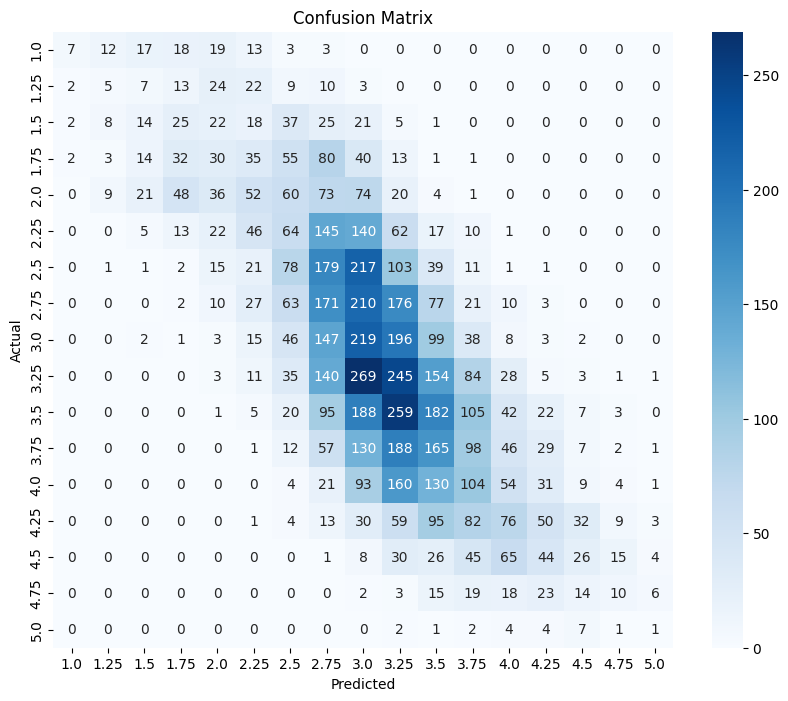

Accuracy: 0.1609
Mean Squared Error: 0.3411 and Mean Absolute Error: 0.4714


In [14]:
modelCNN = CNN().to(device)
optimizer = optim.Adagrad(modelCNN.parameters(), lr=0.001, weight_decay=0.0001)
#optimizer = optim.Adadelta(modelCNN.parameters(), lr=0.001, weight_decay=0.0001)
#lr = 0.001
train_model(modelCNN, optimizer, num_epochs=120)

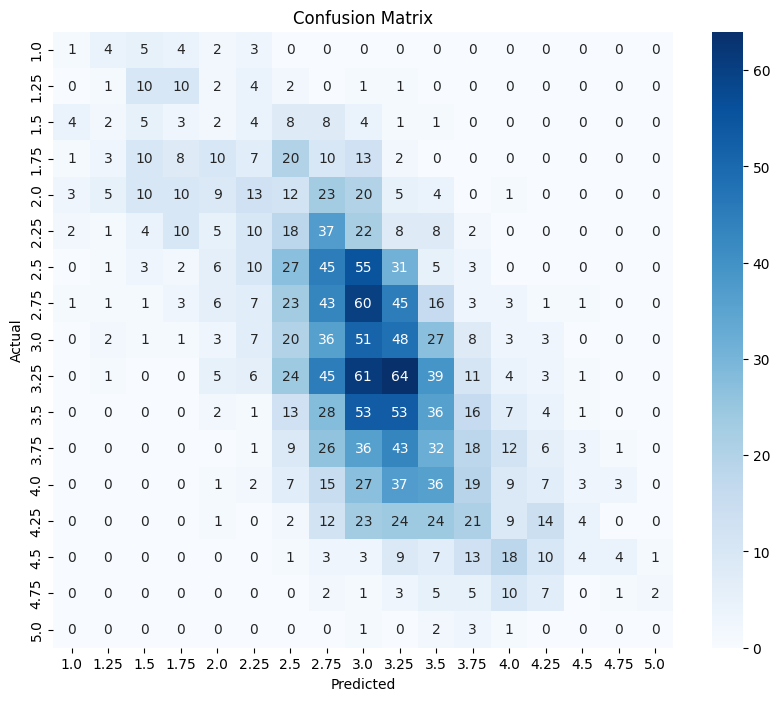

Accuracy: 0.1426


'Mean Squared Error: 0.4346 and Mean Absolute Error: 0.5295'

In [16]:
############################################################################################################
### Load the model
def load_model(epoch, save_dir='model_checkpoint'):
    model = CNN()
    optimizer = optim.Adagrad(model.parameters(), lr=0.001, weight_decay=0.0001)  
    checkpoint = torch.load(os.path.join(save_dir, f'model_epoch_{epoch}.pth'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)  
    model.eval()
    return model, optimizer, epoch


loaded_epoch = 118  # Epoch to evaluate
loaded_model, loaded_optimizer, loaded_epoch = load_model(loaded_epoch)

# Evaluate the loaded model
evaluate_model(loaded_model, validation_loader, conf=True)

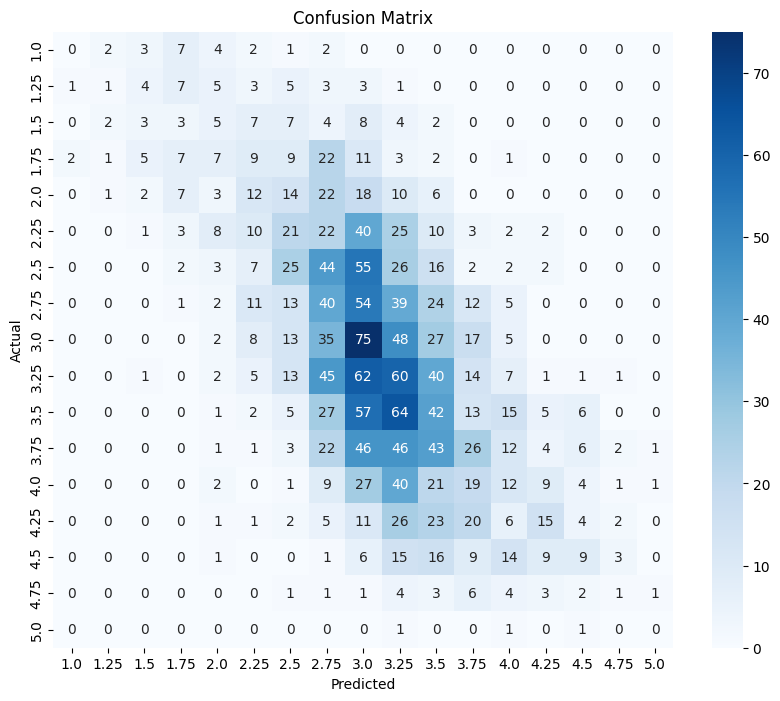

Accuracy: 0.1558
<class 'str'>


In [18]:
m = evaluate_model(modelCNN, test_loader, conf=True)
print(type(m))